In [1]:
import hdf5storage

# Pick just ONE file that failed and look inside it
test_file = r"C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Healthy data\K001\N09_M07_F10_K001_1.mat"
content = hdf5storage.loadmat(test_file)

print("The names found inside this file are:")
print(content.keys())

The names found inside this file are:
dict_keys(['__header__', '__version__', '__globals__', 'N09_M07_F10_K001_1'])


In [2]:
import hdf5storage
import numpy as np

# Let's look at just one specific file
test_file = r"C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Healthy data\K001\N09_M07_F10_K001_1.mat"

try:
    mat = hdf5storage.loadmat(test_file)
    # Get the filename key
    key = [k for k in mat.keys() if not k.startswith('__')][0]
    
    # Let's look inside 'Y'
    y_data = mat[key][0,0]['Y']
    
    print(f"File: {key}")
    print(f"Inside 'Y', there are {len(y_data[0])} items.")
    
    for i in range(len(y_data[0])):
        item = y_data[0, i]
        # We check the type and shape of each item
        print(f"\nITEM {i}:")
        print(f"  Type: {type(item)}")
        
        # If it's a numpy array, let's see what's inside
        if isinstance(item, np.ndarray):
            print(f"  Shape: {item.shape}")
            # If the shape is small (like 1,1), let's look one level deeper!
            if item.size == 1:
                try:
                    deep_item = item[0,0]
                    print(f"  Deeper Level Shape: {deep_item.shape}")
                except:
                    pass
except Exception as e:
    print(f"Error: {e}")

File: N09_M07_F10_K001_1
Inside 'Y', there are 7 items.

ITEM 0:
  Type: <class 'numpy.void'>

ITEM 1:
  Type: <class 'numpy.void'>

ITEM 2:
  Type: <class 'numpy.void'>

ITEM 3:
  Type: <class 'numpy.void'>

ITEM 4:
  Type: <class 'numpy.void'>

ITEM 5:
  Type: <class 'numpy.void'>

ITEM 6:
  Type: <class 'numpy.void'>


In [3]:
import hdf5storage
import numpy as np

test_file = r"C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Healthy data\K001\N09_M07_F10_K001_1.mat"

mat = hdf5storage.loadmat(test_file)
key = [k for k in mat.keys() if not k.startswith('__')][0]
y_data = mat[key][0,0]['Y']

# Let's look inside ITEM 6 (usually the vibration sensor)
item_6 = y_data[0, 6]

print(f"Names of drawers inside Item 6: {item_6.dtype.names}")

# If 'Data' or 'Value' is in there, let's see how many numbers are inside
for name in item_6.dtype.names:
    data_inside = item_6[name]
    print(f"Drawer '{name}' contains {data_inside.flatten().shape[0]:,} points")

Names of drawers inside Item 6: ('Name', 'Type', 'Data', 'Unit', 'Raster', 'Device', 'XIndex', 'DownSampling', 'Description', 'DisplayIdentifier', 'Path', 'Flags', 'Min', 'Max', 'MinWeak', 'MaxWeak')
Drawer 'Name' contains 1 points
Drawer 'Type' contains 1 points
Drawer 'Data' contains 256,823 points
Drawer 'Unit' contains 0 points
Drawer 'Raster' contains 1 points
Drawer 'Device' contains 1 points
Drawer 'XIndex' contains 1 points
Drawer 'DownSampling' contains 1 points
Drawer 'Description' contains 0 points
Drawer 'DisplayIdentifier' contains 0 points
Drawer 'Path' contains 1 points
Drawer 'Flags' contains 1 points
Drawer 'Min' contains 1 points
Drawer 'Max' contains 1 points
Drawer 'MinWeak' contains 1 points
Drawer 'MaxWeak' contains 1 points


In [4]:
import hdf5storage
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def get_vibration_data(main_folder):
    all_windows = []
    window_size = 512
    file_count = 0
    
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        if os.path.isdir(subfolder_path):
            print(f"Checking subfolder: {subfolder}")
            for filename in os.listdir(subfolder_path):
                if filename.endswith(".mat"):
                    try:
                        mat = hdf5storage.loadmat(os.path.join(subfolder_path, filename))
                        key = [k for k in mat.keys() if not k.startswith('__')][0]
                        
                        # --- THE SAFETY NET ---
                        # We grab Item 6
                        item_6 = mat[key][0,0]['Y'][0, 6]
                        
                        # We look for the 'Data' drawer
                        # If it's wrapped in [0,0], we unwrap it. If not, we take it as is.
                        raw_data = item_6['Data']
                        if raw_data.size == 1:
                            raw_signal = raw_data[0,0].flatten()
                        else:
                            raw_signal = raw_data.flatten()
                        
                        # Only proceed if we actually found signal points
                        if len(raw_signal) > 100:
                            file_count += 1
                            for i in range(0, len(raw_signal) - window_size, window_size):
                                all_windows.append(raw_signal[i : i + window_size])
                    except Exception as e:
                        continue
                        
    print(f"Successfully processed {file_count} files from {main_folder}")
    return np.array(all_windows)

# --- EXECUTION ---
# Re-run the loading with the new "Safety Net"
print("Starting Data Load...")
X_healthy = get_vibration_data(r"C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Healthy data")
X_unhealthy = get_vibration_data(r"C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Unhealthy Data")

# CHECK: If they are still empty, we stop here and fix the path
if len(X_healthy) == 0:
    print("!!! Error: X_healthy is still empty. Check your folder paths or Item index.")
else:
    # 2. Scaling (This is where your error was)
    scaler = MinMaxScaler()
    # We reshape (-1, 1) to make the scaler happy, then back to windows
    X_train = scaler.fit_transform(X_healthy.reshape(-1, 1)).reshape(-1, 512, 1)
    X_test = scaler.transform(X_unhealthy.reshape(-1, 1)).reshape(-1, 512, 1)
    print(f"Final Data Shapes: Train={X_train.shape}, Test={X_test.shape}")

Starting Data Load...
Checking subfolder: K001
Checking subfolder: K002
Checking subfolder: K003
Checking subfolder: K004
Checking subfolder: K005
Checking subfolder: K006
Successfully processed 480 files from C:\Users\sampa\OneDrive\Desktop\Pratice\Capstone Projeect _ Sem2\archive (6)\Healthy data
Checking subfolder: KA01
Checking subfolder: KA03
Checking subfolder: KA04
Checking subfolder: KA05
Checking subfolder: KA06
Checking subfolder: KA07
Checking subfolder: KA08
Checking subfolder: KA09
Checking subfolder: KA15
Checking subfolder: KA16
Checking subfolder: KA22
Checking subfolder: KA30
Checking subfolder: KB23
Checking subfolder: KB24
Checking subfolder: KB27
Checking subfolder: KI01
Checking subfolder: KI03
Checking subfolder: KI04
Checking subfolder: KI05
Checking subfolder: KI07
Checking subfolder: KI08
Checking subfolder: KI14
Checking subfolder: KI16
Checking subfolder: KI17
Checking subfolder: KI18
Checking subfolder: KI21
Successfully processed 2079 files from C:\Users\sa

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt

# 1. Define the "Bottle-neck" Architecture
model = Sequential([
    # Encoder: Compress the 512 points into 64 features
    LSTM(64, activation='relu', input_shape=(512, 1), return_sequences=False),
    
    # Repeat the compressed features 512 times
    RepeatVector(512),
    
    # Decoder: Reconstruct the 512 points back to original
    LSTM(64, activation='relu', return_sequences=True),
    
    # Output Layer
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mae')
model.summary()

# 2. Train the Model
# Note: We use X_train as BOTH input and output.
# We'll use a smaller number of epochs (e.g., 5) first to see how it performs.
history = model.fit(
    X_train, X_train, 
    epochs=5, 
    batch_size=128, 
    validation_split=0.1, 
    shuffle=True
)

C:\Users\sampa\anaconda3\envs\pytorch_gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 512, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 512, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 512, 1)              │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 2447s 1s/step - loss: 0.0187 - val_loss: 0.0204
Epoch 2/5
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 2650s 2s/step - loss: 0.0148 - val_loss: 0.0204
Epoch 3/5
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 2715s 2s/step - loss: 0.0148 - val_loss: 0.0204
Epoch 4/5
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 46507s 28s/step - loss: 0.0147 - val_loss: 0.0204
Epoch 5/5
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 3852s 2s/step - loss: 0.0147 - val_loss: 0.0204


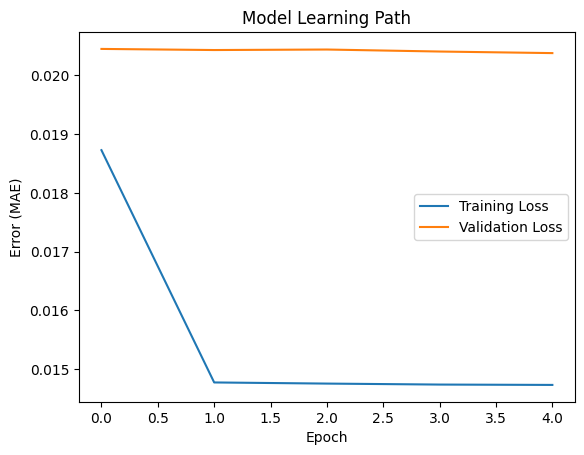

In [6]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Path')
plt.ylabel('Error (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get the AI's "reconstruction" of the data
preds_healthy = model.predict(X_train)
preds_unhealthy = model.predict(X_test)

# 2. Calculate Mean Absolute Error (MAE) for each window
# This is our "Anomaly Score"
mae_healthy = np.mean(np.abs(preds_healthy - X_train), axis=(1, 2))
mae_unhealthy = np.mean(np.abs(preds_unhealthy - X_test), axis=(1, 2))

print("Prediction complete.")

7514/7514 ━━━━━━━━━━━━━━━━━━━━ 727s 97ms/step
32569/32569 ━━━━━━━━━━━━━━━━━━━━ 2513s 77ms/step
Prediction complete.


In [9]:
# Set threshold at the 99th percentile of healthy data
threshold = np.percentile(mae_healthy, 99)

# Create True Labels (0 for Healthy, 1 for Unhealthy)
y_true = np.concatenate([np.zeros(len(mae_healthy)), np.ones(len(mae_unhealthy))])

# Create Predicted Labels based on the threshold
all_errors = np.concatenate([mae_healthy, mae_unhealthy])
y_pred = [1 if e > threshold else 0 for e in all_errors]

print(f"Anomaly Threshold set at: {threshold:.4f}")

Anomaly Threshold set at: 0.0305


Overall Accuracy: 30.13%


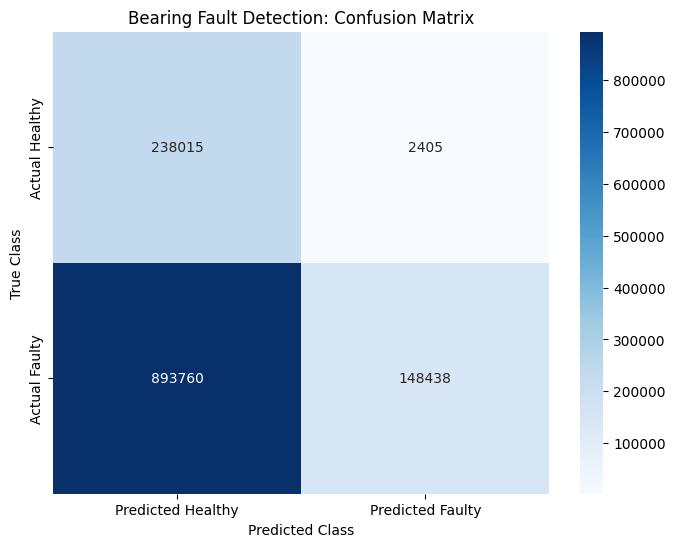


Detailed Classification Report:
              precision    recall  f1-score   support

     Healthy       0.21      0.99      0.35    240420
      Faulty       0.98      0.14      0.25   1042198

    accuracy                           0.30   1282618
   macro avg       0.60      0.57      0.30   1282618
weighted avg       0.84      0.30      0.27   1282618



In [13]:
# 1. Calculate Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc * 100:.2f}%")

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Healthy', 'Predicted Faulty'],
            yticklabels=['Actual Healthy', 'Actual Faulty'])
plt.title('Bearing Fault Detection: Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# 4. Detailed Report (Precision, Recall, F1-Score)
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Faulty']))

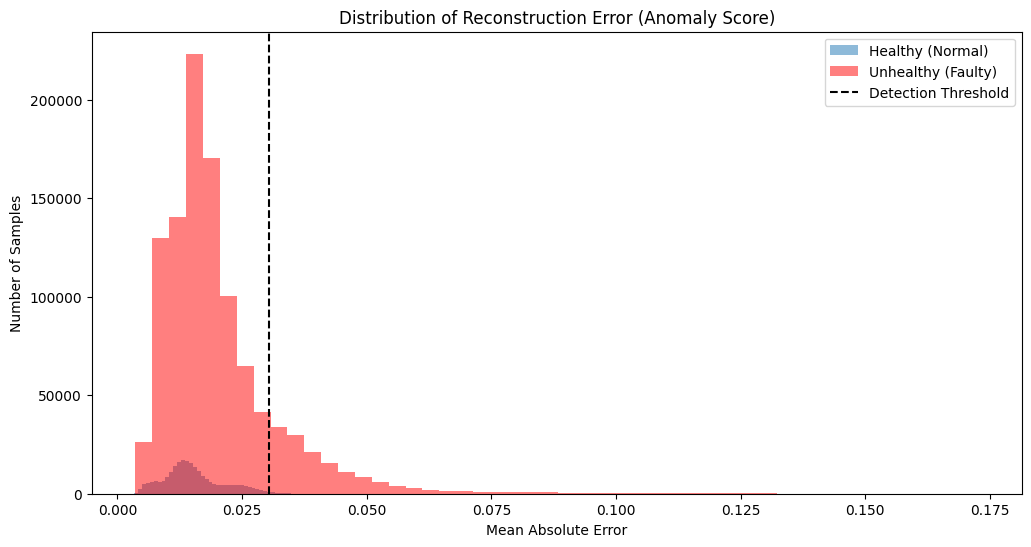

In [14]:
plt.figure(figsize=(12, 6))
plt.hist(mae_healthy, bins=50, alpha=0.5, label='Healthy (Normal)')
plt.hist(mae_unhealthy, bins=50, alpha=0.5, label='Unhealthy (Faulty)', color='red')
plt.axvline(threshold, color='black', linestyle='--', label='Detection Threshold')
plt.title('Distribution of Reconstruction Error (Anomaly Score)')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()